# Predicción 2022 CLV

## Contenido
* Cargar data
* Separar 2 series de tiempo (hogar y pospago)
* Ejecutar los 3 métodos validados con intervalo de confianza
* Exportar resultados
* Graficar resultados

In [1]:
import pandas as pd
import numpy as np
from pmdarima.arima import auto_arima
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error,  mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt,ExponentialSmoothing
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
#carga de los datos
TablaBase=pd.read_csv(f'BasePron.csv',sep=';')

In [4]:
TablaBase.sample(10)

,fecha,Variable,valor,linea,fecha2
145,1/8/2020,Total clientes,2751683.000,hogares,2020-08-01
184,1/3/2021,CLV PROMEDIO,2108039.833,hogares,2021-03-01
194,1/5/2021,CLV PROMEDIO,2042178.485,hogares,2021-05-01
44,1/9/2020,CLV PROMEDIO,1137688.399,pospago,2020-09-01
6,1/2/2020,Churn estimado,0.022,pospago,2020-02-01
91,1/7/2021,Churn estimado,0.017,pospago,2021-07-01
87,1/6/2021,ARPU,47509.449,pospago,2021-06-01
174,1/1/2021,CLV PROMEDIO,1951827.572,hogares,2021-01-01
163,1/11/2020,CLV TOTAL,5349576650610.530,hogares,2020-11-01
34,1/7/2020,CLV PROMEDIO,1168723.940,pospago,2020-07-01


##  Preprocesamiento

In [5]:
TablaBase.set_index('fecha2',inplace=True)

In [6]:
TablaBase.index=pd.to_datetime(TablaBase.index)

In [7]:
#seleccionar una serie
SeriePospago=TablaBase[(TablaBase['linea']=='pospago')&(TablaBase['Variable']=='CLV TOTAL')]
SerieHogar=TablaBase[(TablaBase['linea']=='hogares')&(TablaBase['Variable']=='CLV TOTAL')]

In [8]:
SeriePospago

,fecha,Variable,valor,linea
fecha2,,,,
2020-01-01,1/1/2020,CLV TOTAL,5931665961459.650,pospago
2020-02-01,1/2/2020,CLV TOTAL,5970123554537.230,pospago
2020-03-01,1/3/2020,CLV TOTAL,5958333091532.760,pospago
2020-04-01,1/4/2020,CLV TOTAL,6102416018269.380,pospago
2020-05-01,1/5/2020,CLV TOTAL,6191995189538.440,pospago
2020-06-01,1/6/2020,CLV TOTAL,5818946656850.870,pospago
2020-07-01,1/7/2020,CLV TOTAL,6311288093008.480,pospago
2020-08-01,1/8/2020,CLV TOTAL,6279812651511.310,pospago
2020-09-01,1/9/2020,CLV TOTAL,6319768039902.310,pospago


In [9]:
ind = pd.date_range(SeriePospago.index.max(), periods = 15, freq ='MS', name='FECHA')[1:]
ind

DatetimeIndex(['2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='FECHA', freq='MS')

## Modelos
* Se prueban 3 modelos
 * Dado que se tiene menos de 2 años de historia varios modelos no permiten estacionalidad de 12 periodos
1. Sarimax, con estacionalidad 4
2. Sarimax, con estacionalidad 12 y cambio de hiperparámetros
3. Forecast ETS

In [29]:
Resultado = pd.DataFrame()

# 1. Sarimax, con estacionalidad 4

In [30]:
model1_Hogar=sm.tsa.statespace.SARIMAX(SerieHogar['valor'],order=(1, 1, 1),seasonal_order=(1,1,1,4))
model1_Hogar=model1_Hogar.fit()
pred1_Hogar=model1_Hogar.get_forecast(14)
dfAux=pred1_Hogar.predicted_mean.to_frame()
dfAux=dfAux.merge(pred1_Hogar.conf_int(0.25),left_index=True,right_index=True, how='left')
#dfAux
dfAux.columns=['pred','min','max']
dfAux['linea']='hogar'
dfAux['metodo']='samimax_4'
Resultado=dfAux

C:\ProgramData\Anaconda3\envs\ds_sqdm_claro\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\envs\ds_sqdm_claro\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\envs\ds_sqdm_claro\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\envs\ds_sqdm_claro\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found

In [31]:
model1_Pospago=sm.tsa.statespace.SARIMAX(SeriePospago['valor'],order=(1, 1, 1),seasonal_order=(1,1,1,4))
model1_Pospago=model1_Pospago.fit()
pred1_Pospago=model1_Pospago.get_forecast(14)
dfAux=pred1_Pospago.predicted_mean.to_frame()
dfAux=dfAux.merge(pred1_Pospago.conf_int(0.25),left_index=True,right_index=True, how='left')
dfAux.columns=['pred','min','max']
dfAux['linea']='pospago'
dfAux['metodo']='samimax_4'
Resultado=Resultado.append(dfAux)

C:\ProgramData\Anaconda3\envs\ds_sqdm_claro\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\envs\ds_sqdm_claro\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\envs\ds_sqdm_claro\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\envs\ds_sqdm_claro\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


# 2. Sarimax, estacionalidad 12
##### (ajustes hiperparámetros)

In [32]:
model2_Hogar = sm.tsa.SARIMAX(SerieHogar['valor'],seasonal_order=(1,1,0,12))
model2_Hogar = model2_Hogar.fit()
pred2_Hogar = model2_Hogar.get_forecast(14)
dfAux=pred2_Hogar.predicted_mean.to_frame()
dfAux=dfAux.merge(pred2_Hogar.conf_int(0.25),left_index=True,right_index=True, how='left')
dfAux.columns=['pred','min','max']
dfAux['linea']='hogar'
dfAux['metodo']='samimax_12'
Resultado=Resultado.append(dfAux)

C:\ProgramData\Anaconda3\envs\ds_sqdm_claro\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\envs\ds_sqdm_claro\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\envs\ds_sqdm_claro\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [33]:
model2_Pospago = sm.tsa.SARIMAX(SeriePospago['valor'],seasonal_order=(0,1,0,12))
model2_Pospago = model2_Pospago.fit()
pred2_Pospago = model2_Pospago.get_forecast(14)
dfAux=pred2_Pospago.predicted_mean.to_frame()
dfAux=dfAux.merge(pred2_Pospago.conf_int(0.25),left_index=True,right_index=True, how='left')
dfAux.columns=['pred','min','max']
dfAux['linea']='pospago'
dfAux['metodo']='samimax_12'
Resultado=Resultado.append(dfAux)

C:\ProgramData\Anaconda3\envs\ds_sqdm_claro\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\envs\ds_sqdm_claro\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


# 3. ETS,  estacionalidad 10

In [34]:
model3_Hogar = ETSModel(SerieHogar['valor'],seasonal_periods=10,error="mul",trend="mul",seasonal="mul", damped_trend=False,)
model3_Hogar = model3_Hogar.fit()
pred3_Hogar = model3_Hogar.get_prediction(start=22, end=22+13)
dfAux=pred3_Hogar.summary_frame(alpha=0.25)
dfAux.drop(columns=['mean_numerical'], inplace=True)
dfAux.columns=['pred','min','max']
dfAux['linea']='hogar'
dfAux['metodo']='ETS_10'
Resultado=Resultado.append(dfAux)

C:\ProgramData\Anaconda3\envs\ds_sqdm_claro\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [35]:
model3_Pospago = ETSModel(SeriePospago['valor'],seasonal_periods=10,error="mul",trend="mul",seasonal="mul", damped_trend=False,)
model3_Pospago = model3_Pospago.fit()
pred3_Pospago = model3_Pospago.get_prediction(start=22, end=22+13)
#pred3_Hogar.predicted_mean
dfAux=pred3_Pospago.summary_frame(alpha=0.25)
dfAux.drop(columns=['mean_numerical'], inplace=True)
dfAux.columns=['pred','min','max']
dfAux['linea']='pospago'
dfAux['metodo']='ETS_10'
Resultado=Resultado.append(dfAux)

C:\ProgramData\Anaconda3\envs\ds_sqdm_claro\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


## Guardar resultado

In [36]:
Resultado

,pred,min,max,linea,metodo
2021-11-01,6792784882367.606,6422206481677.084,7163363283058.129,hogar,samimax_4
2021-12-01,6634388111833.646,6119355085272.916,7149421138394.375,hogar,samimax_4
2022-01-01,6719753702722.531,6091542238160.990,7347965167284.072,hogar,samimax_4
2022-02-01,7042302877199.870,6318556046860.709,7766049707539.031,hogar,samimax_4
2022-03-01,7396361411139.197,6367941717526.736,8424781104751.658,hogar,samimax_4
...,...,...,...,...,...
2022-08-01,6286663478453.516,5864657605326.219,6657537220783.248,pospago,ETS_10
2022-09-01,6315640016831.509,5862145957703.738,6694279993785.168,pospago,ETS_10
2022-10-01,6402873769390.654,5921681391547.617,6828346674163.155,pospago,ETS_10
2022-11-01,6421437767888.008,5938106390455.069,6844659191501.206,pospago,ETS_10


In [37]:
Resultado.to_csv('resultado.csv')

## Revisión Visual

In [38]:
del fig
del ax

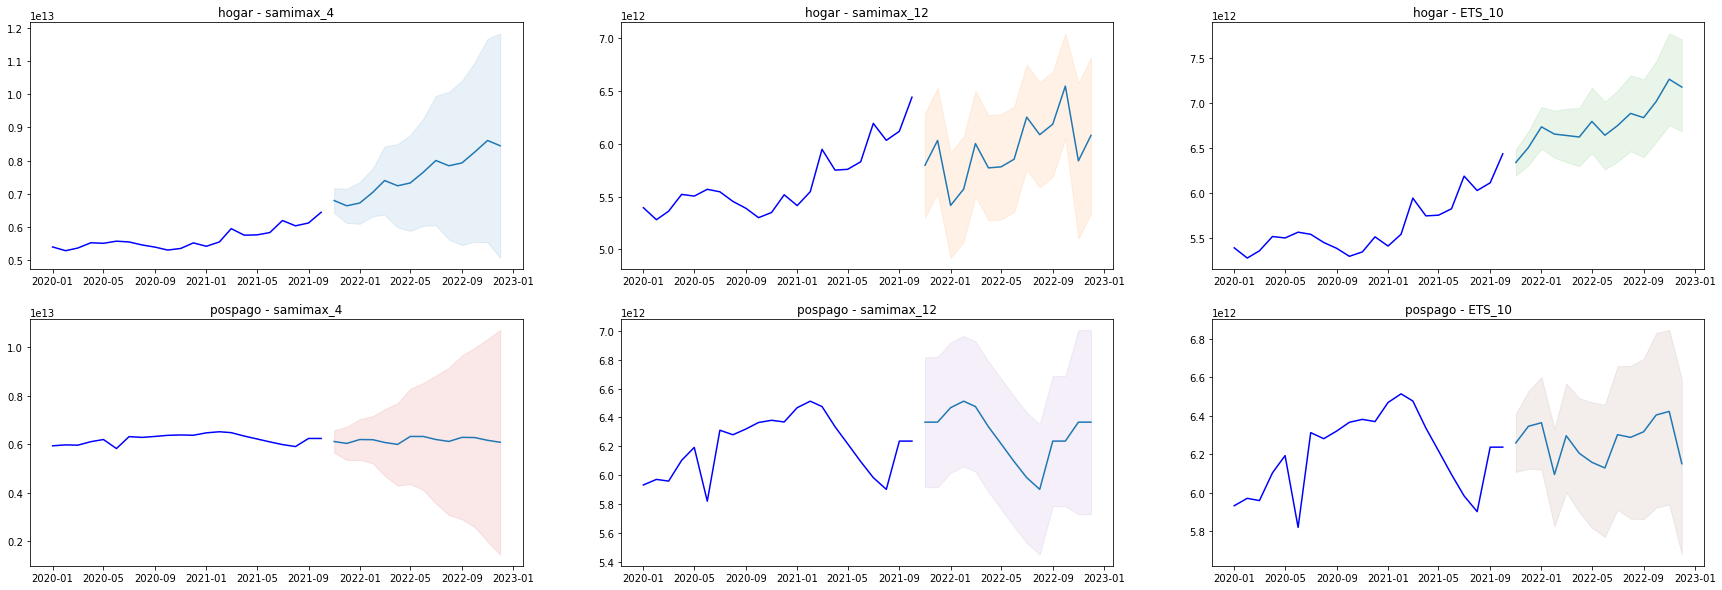

In [39]:
fig, ax = plt.subplots(2,3,figsize=(30,10))
auxDf=Resultado[(Resultado['linea']=='hogar')&(Resultado['metodo']=='samimax_4')]
ax[0,0].plot(SerieHogar.index,SerieHogar['valor'], color='b')
ax[0,0].plot(auxDf.index,auxDf['pred'])
ax[0,0].fill_between(auxDf.index, auxDf['min'], auxDf['max'], color='C0', alpha=.1)
ax[0,0].set_title('hogar - samimax_4')
auxDf=Resultado[(Resultado['linea']=='hogar')&(Resultado['metodo']=='samimax_12')]
ax[0,1].plot(SerieHogar.index,SerieHogar['valor'], color='b')
ax[0,1].plot(auxDf.index,auxDf['pred'])
ax[0,1].fill_between(auxDf.index, auxDf['min'], auxDf['max'], color='C1', alpha=.1)
ax[0,1].set_title('hogar - samimax_12')
auxDf=Resultado[(Resultado['linea']=='hogar')&(Resultado['metodo']=='ETS_10')]
ax[0,2].plot(SerieHogar.index,SerieHogar['valor'], color='b')
ax[0,2].plot(auxDf.index,auxDf['pred'])
ax[0,2].fill_between(auxDf.index, auxDf['min'], auxDf['max'], color='C2', alpha=.1)
ax[0,2].set_title('hogar - ETS_10')
auxDf=Resultado[(Resultado['linea']=='pospago')&(Resultado['metodo']=='samimax_4')]
ax[1,0].plot(SeriePospago.index,SeriePospago['valor'], color='b')
ax[1,0].plot(auxDf.index,auxDf['pred'])
ax[1,0].fill_between(auxDf.index, auxDf['min'], auxDf['max'], color='C3', alpha=.1)
ax[1,0].set_title('pospago - samimax_4')
auxDf=Resultado[(Resultado['linea']=='pospago')&(Resultado['metodo']=='samimax_12')]
ax[1,1].plot(SeriePospago.index,SeriePospago['valor'], color='b')
ax[1,1].plot(auxDf.index,auxDf['pred'])
ax[1,1].fill_between(auxDf.index, auxDf['min'], auxDf['max'], color='C4', alpha=.1)
ax[1,1].set_title('pospago - samimax_12')
auxDf=Resultado[(Resultado['linea']=='pospago')&(Resultado['metodo']=='ETS_10')]
ax[1,2].plot(SeriePospago.index,SeriePospago['valor'], color='b')
ax[1,2].plot(auxDf.index,auxDf['pred'])
ax[1,2].fill_between(auxDf.index, auxDf['min'], auxDf['max'], color='C5', alpha=.1)
ax[1,2].set_title('pospago - ETS_10')
plt.show()

In [40]:
#Resultado.plot()

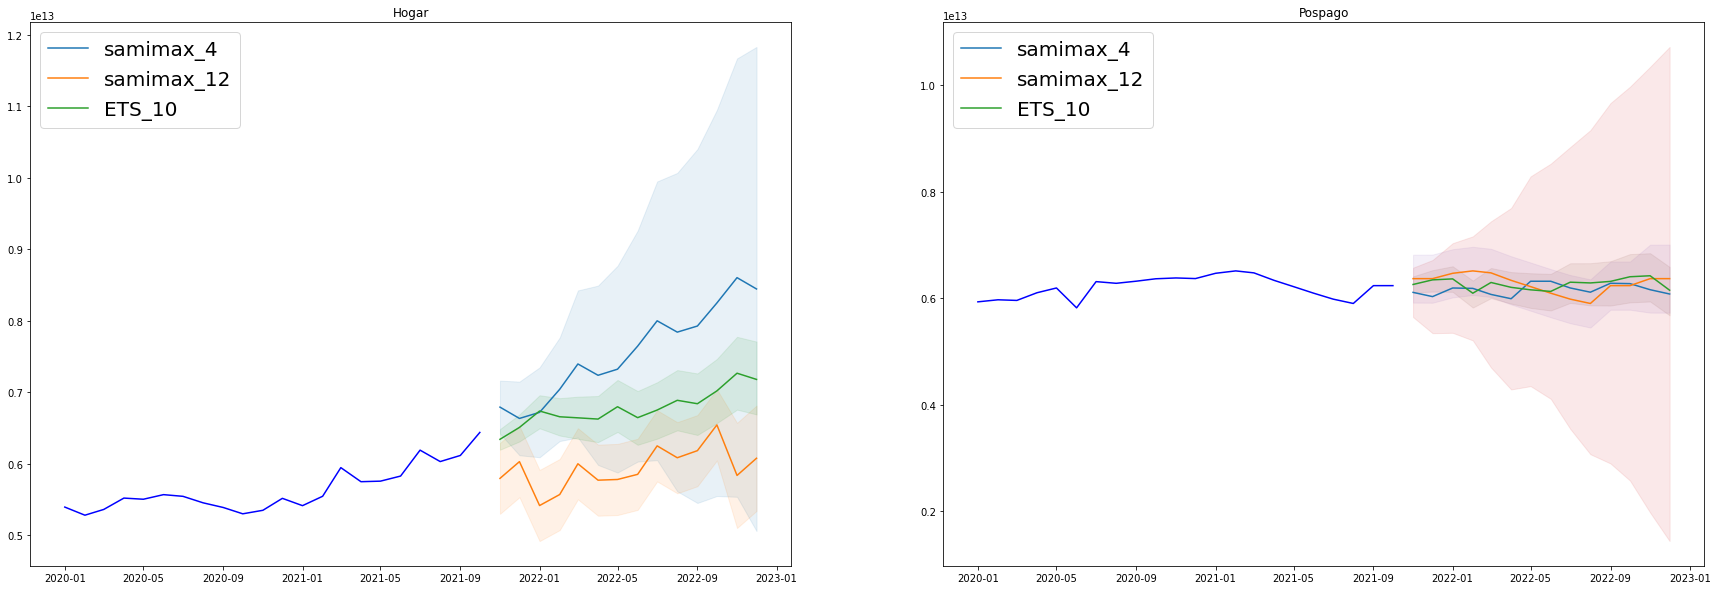

In [41]:
fig, ax = plt.subplots(1,2,figsize=(30,10))
auxDf=Resultado[(Resultado['linea']=='hogar')&(Resultado['metodo']=='samimax_4')]
ax[0].plot(SerieHogar.index,SerieHogar['valor'], color='b')
ax[0].plot(auxDf.index,auxDf['pred'], label='samimax_4')
ax[0].fill_between(auxDf.index, auxDf['min'], auxDf['max'], color='C0', alpha=.1)
ax[0].set_title('Hogar')
auxDf=Resultado[(Resultado['linea']=='hogar')&(Resultado['metodo']=='samimax_12')]
ax[0].plot(auxDf.index,auxDf['pred'], label='samimax_12')
ax[0].fill_between(auxDf.index, auxDf['min'], auxDf['max'], color='C1', alpha=.1)
auxDf=Resultado[(Resultado['linea']=='hogar')&(Resultado['metodo']=='ETS_10')]
ax[0].plot(auxDf.index,auxDf['pred'], label='ETS_10')
ax[0].fill_between(auxDf.index, auxDf['min'], auxDf['max'], color='C2', alpha=.1)
ax[0].legend(loc="upper left", prop={'size': 20})
auxDf=Resultado[(Resultado['linea']=='pospago')&(Resultado['metodo']=='samimax_4')]
ax[1].plot(SeriePospago.index,SeriePospago['valor'], color='b')
ax[1].plot(auxDf.index,auxDf['pred'], label='samimax_4')
ax[1].fill_between(auxDf.index, auxDf['min'], auxDf['max'], color='C3', alpha=.1)
ax[1].set_title('Pospago')
auxDf=Resultado[(Resultado['linea']=='pospago')&(Resultado['metodo']=='samimax_12')]
ax[1].plot(auxDf.index,auxDf['pred'], label='samimax_12')
ax[1].fill_between(auxDf.index, auxDf['min'], auxDf['max'], color='C4', alpha=.1)
auxDf=Resultado[(Resultado['linea']=='pospago')&(Resultado['metodo']=='ETS_10')]
ax[1].plot(auxDf.index,auxDf['pred'], label='ETS_10')
ax[1].fill_between(auxDf.index, auxDf['min'], auxDf['max'], color='C5', alpha=.1)
ax[1].legend(loc="upper left", prop={'size': 20})
plt.show()

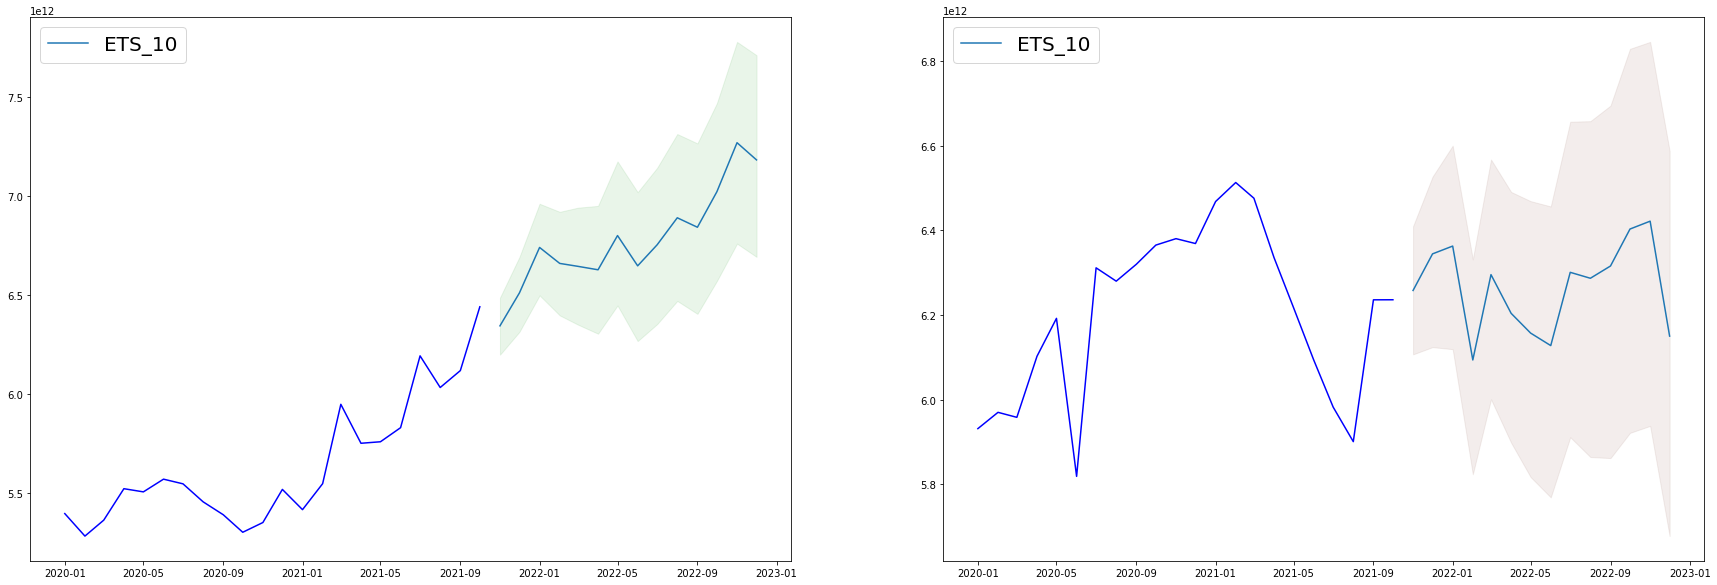

In [42]:
fig, ax = plt.subplots(1,2,figsize=(30,10))
auxDf=Resultado[(Resultado['linea']=='hogar')&(Resultado['metodo']=='samimax_4')]
ax[0].plot(SerieHogar.index,SerieHogar['valor'], color='b')
auxDf=Resultado[(Resultado['linea']=='hogar')&(Resultado['metodo']=='ETS_10')]
ax[0].plot(auxDf.index,auxDf['pred'], label='ETS_10')
ax[0].fill_between(auxDf.index, auxDf['min'], auxDf['max'], color='C2', alpha=.1)
ax[0].legend(loc="upper left", prop={'size': 20})
auxDf=Resultado[(Resultado['linea']=='pospago')&(Resultado['metodo']=='samimax_4')]
ax[1].plot(SeriePospago.index,SeriePospago['valor'], color='b')
auxDf=Resultado[(Resultado['linea']=='pospago')&(Resultado['metodo']=='ETS_10')]
ax[1].plot(auxDf.index,auxDf['pred'], label='ETS_10')
ax[1].fill_between(auxDf.index, auxDf['min'], auxDf['max'], color='C5', alpha=.1)
ax[1].legend(loc="upper left", prop={'size': 20})
plt.show()